In [1]:
using LinearAlgebra 
using CairoMakie 

In [2]:
function tran_base_0(a::Int)  #forget zero 
    cut=Vector{Tuple{Int,Int}}()
    for n=0:a,k=0:n
        push!(cut,(n-k,k))
    end
    return cut
end

tran_base_0 (generic function with 1 method)

In [3]:
function tran_intergral(a::Int,b::Int)
    res= (factorial(big(a))*factorial(big(b))) / (factorial(big(a + b + 2)))
    return res
end


tran_intergral (generic function with 1 method)

In [4]:
function tran_2()
    x_1=-0.5
    y_1=-sqrt(3)/6
    A=[1.0 0.5;0.0 sqrt(3)/2]
    detA = abs(det(A))            
    return x_1,y_1,A,detA
end

tran_2 (generic function with 1 method)

In [5]:
function eq_tran_intergral(m::Int, n::Int)
    x_1, y_1, A, detA=tran_2()
    a_1_1=A[1,1]
    a_1_2=A[1,2]
    a_2_1=A[2,1]
    a_2_2=A[2,2]
    coefficient=0 
    for a = 0:m              
        cx_1= binomial(m,a) * x_1^(m-a)
        for i = 0:a
            cx_2= cx_1 * binomial(a,i) * (a_1_1)^i * (a_1_2)^(a-i)

            for b = 0:n        
                cy_1 = binomial(n,b) * y_1^(n-b)
                for j = 0:b
                    cy_2 = cy_1 * binomial(b,j) * (a_2_1)^j * (a_2_2)^(b-j)

                    p = i + j                
                    q = (a-i) + (b-j)        
                    coefficient=coefficient+ cx_2*cy_2*tran_intergral(p,q)
                end
                
            end
            
        end
        
    end
    return detA *coefficient
end

eq_tran_intergral (generic function with 1 method)

In [6]:
function pde_L_V(a::Int)
    tran_base_1=tran_base_0(a)
    b=length(tran_base_1)
    L=zeros(b,b)
    V=zeros(b,b)

    for i in 1:b, j in 1:b
        k_1,l_1 = tran_base_1[i]
        k_2,l_2 = tran_base_1[j]

        #L
        if k_1>0 && k_2>0
            L[i,j]=L[i,j] +  k_1*k_2 * eq_tran_intergral(k_1+k_2-2, l_1+l_2)
        end
        
        if l_1>0 && l_2>0
            L[i,j] = L[i,j] + l_1*l_2 * eq_tran_intergral(k_1+k_2, l_1+l_2-2)
        end


        
        #V
        V[i,j]=eq_tran_intergral(k_1+k_2+2,l_1+l_2)
        V[i,j]=V[i,j] + eq_tran_intergral(k_1+k_2,l_1+l_2+2)
    end
    return L,V,tran_base_1
end

pde_L_V (generic function with 1 method)

In [7]:
function blockdiag(M_1::AbstractMatrix...)
    m=sum(size(A,1) for A in M_1) 
    n=sum(size(A,2) for A in M_1)
    t=promote_type(map(eltype, M_1)...)
    M=zeros(t, m, n)
    i=1 
    j=1
    for A in M_1
        M[i:i+size(A,1)-1, j:j+size(A,2)-1] .= A
        i=i+size(A,1)
        j=j+size(A,2)
    end
    return M
end

blockdiag (generic function with 1 method)

In [8]:
function rho_ele(n::Int, B::AbstractMatrix{<:Real})
    b_1_1=B[1,1]
    b_1_2=B[1,2]
    b_2_1=B[2,1]
    b_2_2=B[2,2]
    de=n+1
    R= zeros(Float64, de, de)
    for k in 0:n
        for i in 0:(n-k), j in 0:k
            coeff=binomial(n-k,i)*binomial(k,j)*(b_1_1)^i*(b_1_2)^(n-k-i)*(b_2_1)^j*(b_2_2)^(k-j)
            row=n - (i+j)
            R[row+1,k+1] += coeff
        end
    end
    w= [sqrt(binomial(n,k)) for k in 0:n]
    W= Diagonal(w)
    return W\(R*W)         
end

rho_ele (generic function with 1 method)

In [9]:
using LinearAlgebra

function Q_n_D_3(n::Int; tol = 1e-12, ta = 0.35, order = :asc)
    
    R120= [-0.5 -sqrt(3)/2;sqrt(3)/2 -0.5]
    Sx= [-1.0 0.0; 0.0 1.0]

  
    r = rho_ele(n, R120)
    s = rho_ele(n, Sx)
    d=n + 1
    I_d=I(d)

   
    r_2= r*r
    s_r= s*r
    sr_2= s*r_2

    P_triv=(I_d +(r + r_2)+(s+s_r+sr_2))/6
    P_sign=(I_d +(r + r_2)-(s+s_r+sr_2))/6
    P_std=I_d - P_triv - P_sign

    
    basis_from_P(P) = begin
        EIG,V= eigen(Symmetric(P))
        idx= findall(>(0.5), EIG)
        if isempty(idx)
            zeros(Float64, d, 0)
        else
            Qfull = qr(V[:, idx]).Q
            Matrix(Qfull[:, 1:length(idx)])
        end
    end

    Q_t= basis_from_P(P_triv)
    Qs= basis_from_P(P_sign)
    Qstd0= basis_from_P(P_std)

    
    if size(Qstd0,2) == 0
        Qn= hcat(Q_t, Qs, Qstd0)
        return Qn, Qn' *r*Qn, Qn' *s*Qn, (size(Q_t,2), size(Qs,2), size(Qstd0,2))
    end

    
    D_tao= [exp(ta) 0.0;0.0 exp(-ta)]
    M= rho_ele(n, D_tao)                      
    K= Symmetric(Qstd0' * M*Qstd0)       
    EIGm,U_m =eigen(K)                         

    
    perm_desc= sortperm(EIGm, rev=true)        
    EIG_srt= EIGm[perm_desc]
    Usrt= U_m[:, perm_desc]
    L=length(EIG_srt)
    @assert iseven(L) 
    
    pair_s=order===:asc ? collect(Iterators.reverse(1:(L÷2))) : collect(1:(L÷2))

    Qstd1 = Matrix{Float64}(undef, d, 0)
    for k in pair_s
        i_big= k
        i_small=L-(k - 1)



        
        Q_pair = Qstd0 * Usrt[:, [i_big, i_small]]

        
        Ar= Q_pair' * r*Q_pair
        sch= schur(Ar)              
        Q_pair=Q_pair *sch.Z

        
        Bs = Symmetric(Q_pair' * s*Q_pair)
        EIGs, U_s = eigen(Bs)
        Q_pair = Q_pair * U_s[:, sortperm(EIGs, rev=true)] 

        Qstd1 = hcat(Qstd1, Q_pair)
    end

    
    if isodd(size(Qstd1, 2))
        Qstd1 = Qstd1[:, 1:end-1]
    end

    
    Qn= hcat(Q_t, Qs, Qstd1)
    size_s = (size(Q_t,2), size(Qs,2), size(Qstd1,2))
    return Qn, Qn' *r* Qn, Qn' *s*Qn, size_s
end




Q_D_3(n::Int)= Q_n_D_3(n)[1]
Q_de_num_D3(n::Int)= Q_n_D_3(n)[4]


Q_de_num_D3 (generic function with 1 method)

In [10]:
function dihe_rep_big(i::Int)
    R_120=[-0.5 -sqrt(3)/2; sqrt(3)/2 -0.5]
    S_x=[-1.0 0.0 ;0.0  1.0]
    Rs=[rho_ele(n, R_120) for n in 0:i]
    Ss=[rho_ele(n, S_x) for n in 0:i]
    big_r=blockdiag(Rs...)
    big_s=blockdiag(Ss...)
    return big_r,big_s
end



dihe_rep_big (generic function with 1 method)

In [11]:
function permu_irr_4(a::Int,b::Vector{Vector{Int}})
    d= [n+1 for n in 0:a]
    s= cumsum(vcat(0, d[1:end-1]))

    t_pai=Int[]
    s_pai=Int[]
    E_1= Int[]
    E_2= Int[]

    for (n,f) in zip(0:a,s)
        t,g,st=b[n+1]  
        
        append!(t_pai,(f+1):(f+t))
        append!(s_pai,(f+t+1):(f+t+g))
    
        base=f+t+g
        for k = 0:2:(st-1)
            push!(E_1,base+k+1)   
            push!(E_2,base+k+2)   
        end
    end
    return vcat(t_pai,s_pai,E_1,E_2)
end

permu_irr_4 (generic function with 1 method)

In [12]:
function plot_blocks(A_mask::BitMatrix; title_str="")
    fig = Figure(size=(600, 520))
    ax  = Axis(fig[1,1]; title=title_str, yreversed=true)

    Aimgage = Float32.(A_mask)            
    heatmap!(ax, Aimgage;interpolate=false,colormap = [:white, :brown],colorrange=(0.0, 1.0))

    xlims!(ax, 0.5,size(Aimgage,2)+0.5)
    ylims!(ax, 0.5,size(Aimgage,1)+0.5)
    return fig
end


plot_blocks (generic function with 1 method)

In [13]:
using LinearAlgebra, Printf, CairoMakie

function final_A(degree::Int)
    L,V,_=pde_L_V(degree)

    
    Qbig= Diagonal([sqrt(binomial(n,k)) for n in 0:degree for k in 0:n])
    Ls= Qbig*L*Qbig
    Vs= Qbig*V*Qbig
    A= Ls+Vs #A = Ls 

    
    big_r, big_s = dihe_rep_big(degree)
    @printf "A−rAr=%.2e\n" norm(big_r' * A*big_r   - A)
    @printf "A−sAs=%.2e\n" norm(big_s' * A*big_s   - A)

    
    Qblocks=[Q_D_3(n) for n in 0:degree]
    sizes_tuple= [Q_de_num_D3(n) for n in 0:degree]   # cannot use size to be the name 
    sizes_vec=[Int[t,g,st] for (t,g,st) in sizes_tuple]      #Vector{Vector{Int}}

    Qbig0= blockdiag(Qblocks...)
    A_step1= Qbig0' *A*Qbig0

    perm_4=permu_irr_4(degree, sizes_vec)
    A_iso=A_step1[perm_4, perm_4]

    
    thr_ta= 1e-12 * opnorm(A_iso)
    A_mask_orig= abs.(A)    .> thr_ta
    A_mask_iso= abs.(A_iso) .> (1e-12 * opnorm(A_iso))
    
    fig1 = plot_blocks(A_mask_orig; title_str="orginial matirx")
    fig2 = plot_blocks(A_mask_iso; title_str="Dinedral-decoupled matirx")

    return A_mask_orig, A_mask_iso,fig1,fig2,A,A_iso
end


final_A (generic function with 1 method)

In [14]:
@time final_A(12) 

A−rAr=2.54e-13
A−sAs=2.41e-13
141.215508 seconds (1.68 G allocations: 50.347 GiB, 16.81% gc time, 1.50% compilation time: 3% of which was recompilation)


(Bool[1 0 … 0 1; 0 1 … 1 0; … ; 0 1 … 1 0; 1 0 … 0 1], Bool[1 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1], Scene (600px, 520px):
  0 Plots
  1 Child Scene:
    └ Scene (600px, 520px), Scene (600px, 520px):
  0 Plots
  1 Child Scene:
    └ Scene (600px, 520px), [0.03608439182435161 8.180310862583276e-79 … -3.30819462652951e-20 7.371002195550062e-7; 8.180310862583276e-79 0.4354183280138427 … 2.0215478357546766e-5 6.695996299345057e-20; … ; -3.30819462652951e-20 2.0215478357546766e-5 … 5.551127018866131e-8 1.3444317736332227e-19; 7.371002195550062e-7 6.695996299345057e-20 … 1.3444317736332227e-19 5.671323542911092e-7], [0.03608439182435161 -0.0034020690871988573 … -2.80362980214665e-17 -7.122561658748458e-18; -0.0034020690871988573 0.07258404053874531 … 4.1893171107980126e-16 -1.5677306869170377e-18; … ; -2.80362980214665e-17 4.189317110798012e-16 … 2.5040063930798203e-7 -1.862845926125541e-8; -7.122561658748458e-18 -1.5677306869170373e-18 … -1.862845926125541e-8 1.4719532594450604e-8])

In [15]:
A_mask_orig, A_mask_iso,fig3,fig4,A,A_iso = final_A(12) 

A−rAr=2.54e-13
A−sAs=2.41e-13


(Bool[1 0 … 0 1; 0 1 … 1 0; … ; 0 1 … 1 0; 1 0 … 0 1], Bool[1 1 … 0 0; 1 1 … 0 0; … ; 0 0 … 1 1; 0 0 … 1 1], Scene (600px, 520px):
  0 Plots
  1 Child Scene:
    └ Scene (600px, 520px), Scene (600px, 520px):
  0 Plots
  1 Child Scene:
    └ Scene (600px, 520px), [0.03608439182435161 8.180310862583276e-79 … -3.30819462652951e-20 7.371002195550062e-7; 8.180310862583276e-79 0.4354183280138427 … 2.0215478357546766e-5 6.695996299345057e-20; … ; -3.30819462652951e-20 2.0215478357546766e-5 … 5.551127018866131e-8 1.3444317736332227e-19; 7.371002195550062e-7 6.695996299345057e-20 … 1.3444317736332227e-19 5.671323542911092e-7], [0.03608439182435161 -0.0034020690871988573 … -2.80362980214665e-17 -7.122561658748458e-18; -0.0034020690871988573 0.07258404053874531 … 4.1893171107980126e-16 -1.5677306869170377e-18; … ; -2.80362980214665e-17 4.189317110798012e-16 … 2.5040063930798203e-7 -1.862845926125541e-8; -7.122561658748458e-18 -1.5677306869170373e-18 … -1.862845926125541e-8 1.4719532594450604e-8])

In [16]:
A

91×91 Matrix{Float64}:
  0.0360844     8.18031e-79   1.89075e-18  …  -3.30819e-20   7.371e-7
  8.18031e-79   0.435418      5.34156e-19      2.02155e-5    6.696e-20
  1.89075e-18   5.34156e-19   0.435418         2.31956e-19   7.03939e-5
  0.00240563   -3.57694e-21  -0.000396825     -1.9979e-20    6.69131e-10
  7.55411e-19  -0.000561196  -5.05856e-21      1.54765e-5    5.83965e-20
  0.00240563   -3.57694e-21   0.000396825  …   1.43042e-19   6.99908e-5
 -3.57694e-21   0.054438      1.05967e-18      4.18278e-8    5.84069e-20
 -0.000687322   1.8354e-18    0.0314298        4.78012e-18   8.45105e-8
 -6.19544e-21   0.0314298     3.27842e-19      9.23342e-6    1.64434e-20
  0.000396825   1.8928e-19    0.054438         3.28867e-20   5.22859e-5
  0.000311443  -4.83086e-19  -6.2004e-5    …   2.6595e-19    2.22039e-11
  2.11934e-18  -0.012624     -1.06151e-18      1.62037e-7   -2.38453e-19
  0.000254292  -1.30007e-18  -0.0102568       -1.82201e-18   1.92156e-7
  ⋮                                   

In [17]:
A_iso

91×91 Matrix{Float64}:
  0.0360844    -0.00340207    0.000793651  …  -2.80363e-17  -7.12256e-18
 -0.00340207    0.072584     -0.0177946        4.18932e-16  -1.56773e-18
  0.000793651  -0.0177946     0.010863         4.21189e-17  -5.23071e-17
 -0.000508584   0.0167394    -0.00585482       8.08707e-16   2.28569e-16
  0.00018486   -0.00630367    0.00327569       1.19536e-15  -1.12863e-17
 -5.7924e-6     0.000369247  -1.3642e-7    …   6.96549e-16  -4.64196e-17
  9.6674e-5    -0.00403058    0.00175007       2.42038e-16   2.68264e-16
  4.24772e-5   -0.00188235    0.000953927     -5.14348e-16   3.37235e-16
 -1.17443e-6    8.78349e-5   -6.13727e-6      -1.02971e-16  -5.47258e-17
 -2.1235e-5     0.00106343   -0.000514095     -1.1077e-15    1.85106e-15
  2.0115e-7    -1.42912e-5    2.91934e-6   …   1.28955e-15   1.08175e-15
  1.01348e-5   -0.000544082   0.000279345      6.99007e-15  -1.37539e-15
 -2.23275e-7    1.87686e-5   -2.47955e-6      -2.88657e-15  -3.06272e-15
  ⋮                         

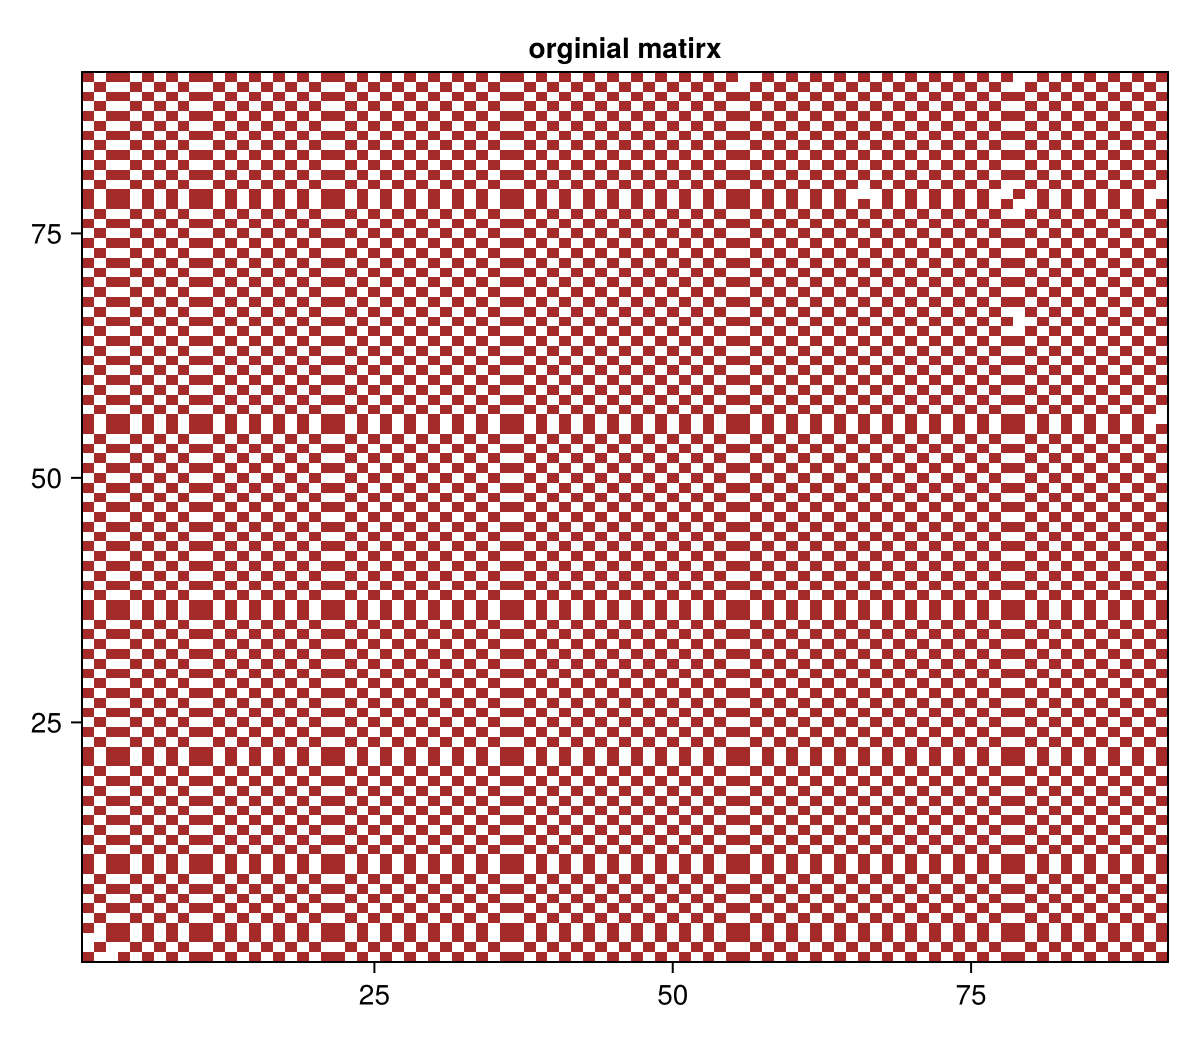

In [18]:
fig3

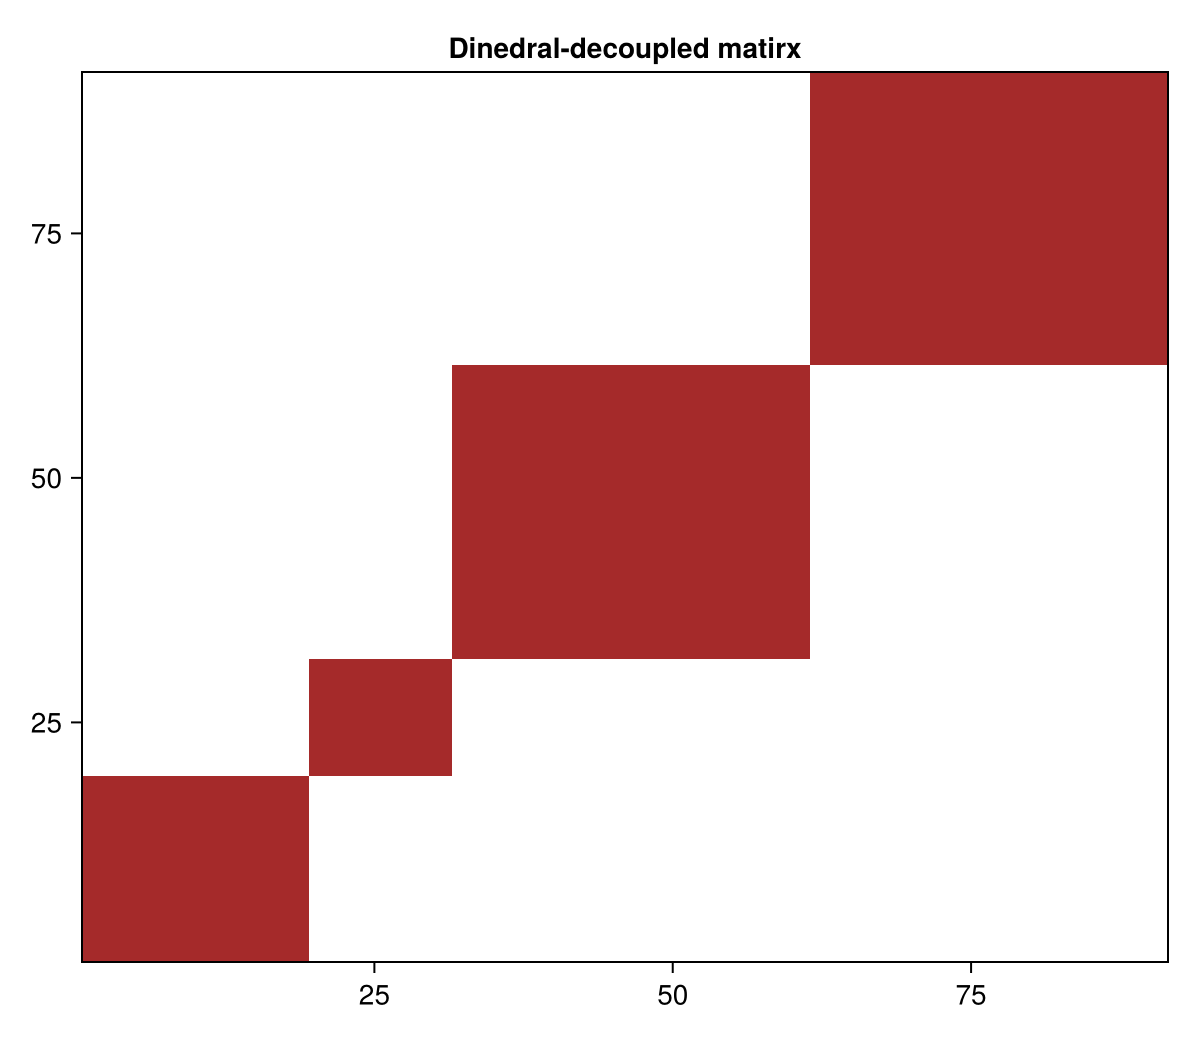

In [19]:
fig4

In [20]:


save(raw"D:\ic\term2\毕业论文\julia 代码\Figures\fig3.png", fig3)
save(raw"D:\ic\term2\毕业论文\julia 代码\Figures\fig4.png", fig4)




    fig3 = plot_blocks(A; title_str="orginial matirx")
    fig4 = plot_blocks(A_iso; title_str="Dinedral-decoupled matirx")

### begin test L

In [21]:
function mass_zhi(n::Int)
    base=tran_base_0(n)
    m=length(base)
    M = zeros(m,m)
    for i in 1:m, j in 1:m
        k_1,l_1 = base[i];  k_2,l_2 = base[j]
        M[i,j] = eq_tran_intergral(k_1 + k_2, l_1 + l_2)
    end
    return M, base
end


mass_zhi (generic function with 1 method)

In [22]:
function dao_map(n::Int)
    @assert n >= 1
    basis_hi_1= tran_base_0(n)      # ≤deg 的基
    basis_lo_2= tran_base_0(n-1)    # ≤deg-1 的基
    idx_lo= Dict{Tuple{Int,Int},Int}((kl,i) for (i,kl) in enumerate(basis_lo_2))

    nb_hi,nb_lo= length(basis_hi_1), length(basis_lo_2)
    Dx= zeros(nb_lo, nb_hi)
    Dy= zeros(nb_lo, nb_hi)
    for (j,(k,l)) in enumerate(basis_hi_1)
        if k > 0
            Dx[idx_lo[(k-1,l)], j]=k
        end
        if l > 0
            Dy[idx_lo[(k,l-1)], j]=l
        end
    end
    return Dx, Dy,   basis_hi_1,basis_lo_2
end

dao_map (generic function with 1 method)

In [23]:
function apply_rho_scaling(L, Dx, Dy, Mass_lo, deg::Int)
    # advance scaling
    w_hi=[sqrt(binomial(n,k)) for n in 0:deg for k in 0:n]
    S_hi=Diagonal(w_hi)
    w_lo=[sqrt(binomial(n,k)) for n in 0:(deg-1) for k in 0:n]
    S_lo=Diagonal(w_lo)

    L.= S_hi*L*S_hi
    Dx.= S_lo\(Dx * S_hi)  
    Dy.= S_lo\(Dy * S_hi)
    Mass_lo.= S_lo' * Mass_lo*S_lo

    return nothing
end

apply_rho_scaling (generic function with 1 method)

In [24]:
function check_L(deg::Int; trials::Int=10, seed::Int=42, scaled::Bool=false)
    @assert deg >= 1 "deg must be ≥ 1 to have a derivative"
   
    L, V, basis_asm = pde_L_V(deg)
    
    Dx, Dy, basis_hi_1, _ =dao_map(deg)
    Mass_lo, _ =mass_zhi(deg-1)
   
    if basis_asm != basis_hi_1
        @warn "The order of basis returned by pde is inconsistent with that of triangle_basis; please unify the order first."
    end

    if scaled
        apply_rho_scaling(L, Dx, Dy, Mass_lo, deg)
    end
    
    L_hat= Dx' *Mass_lo* Dx + Dy' * Mass_lo * Dy
    nL= max(opnorm(L), 1e-300)
    abs_err= opnorm(L-L_hat)
    rel_struct=abs_err/nL
    @printf("L - (Dx' M Dx + Dy' M Dy) = %.3e (rel = %.3e)\n", abs_err, rel_struct)

end

check_L (generic function with 1 method)

In [25]:
check_L(12)

L - (Dx' M Dx + Dy' M Dy) = 9.029e-18 (rel = 2.047e-17)
